# Telco Customer Churn Prediction

## Problem statement
Customer churn is the loss of clients of a company, and it is one of the most important metrics in a business setting. It costs less to retain a defecting customer then to acquire a new one. In this project the goal is to predict customer churn of a fictive telco in California, and classify its customers in two groups: those that would remain, and those that would leave. If a customer is predicted to be thinking of leaving the company, that will affect the revenue of the telco, so there should be a motivation to make the customer rethink their decision by offering them, for e.g., coupons, personalized discounts, etc.

## Table of Contents

### Import libraries

In [2]:
# Data analysis
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
%matplotlib inline

# Modelling
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingClassifier as gb
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgb
from catboost import CatBoostClassifier as cbg

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from time import time

import warnings
warnings.filterwarnings('ignore')

## Data Analysis

In [2]:
data = pd.read_excel('data/Telco_customer_churn.xlsx')

In [3]:
df = data.copy()
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In-depth description of the meaning of each feature can be found in [2].

### Summary of Data Frame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
num_feats_n = len(df.drop('Churn Value', axis=1).select_dtypes(np.number).columns)
cat_feats_n = (df.shape[1] - 1) - num_feats_n
print(f'#Numerical features={num_feats_n}, #Categorical features={cat_feats_n}')

#Numerical features=8, #Categorical features=24


Observations:
- `CustomerID` is different for evey user, so it is irrelevant for classification, and will be dropped.
- `Country` has a single value for every example, so will be dropped.
- `State` has a single value for every example, so will be dropped.
- `Lat Long` is irrelevant because there are separate columns for latitutde and longitude, so will be dropped.
- `Churn Label` is directly related to `Churn Value`, so will be dropped.
- `Churn Reason` is information given by the customer after they left the company, so it doesn't have predictibe ability, and will be dropped.
- `Total Charges` is of type `object`, but in fact it should be `np.number`, and will be converted.

| Data set info: |  |
| :--- | :--- |
| Number of features | 31 |
| Number of examples | 7043 |
| Number of numerical features | 8 |
| Number of categorical features | 24 |
| Memory Usage | 1.8+ MB |
| Target | `Churn Value` |
| ML Problem Type | Binary Classification |

### Descriptive statistics

#### Univariate Analysis of Numerical Features

In [6]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


#### Univariate Analysis of Categorical Features

In [7]:
df.select_dtypes(np.object).describe().transpose()

,count,unique,top,freq
CustomerID,7043,7043,3668-QPYBK,1
Country,7043,1,United States,7043
State,7043,1,California,7043
City,7043,1129,Los Angeles,305
Lat Long,7043,1652,"33.964131, -118.272783",5
Gender,7043,2,Male,3555
Senior Citizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,5416
Phone Service,7043,2,Yes,6361


In [8]:
for column in df.select_dtypes(np.object).columns:
    num_values = len(df[column].unique())
    unique_values = df[column].unique()
    if num_values <= 15:
        print(f'{column:<17} ----- {num_values:<5} ----- {unique_values}') # <, >, or ^ symbols to specify left align, right align, or centering, respectively
    else:
        print(f'{column:<17} ----- {num_values:<5}')

CustomerID        ----- 7043 
Country           ----- 1     ----- ['United States']
State             ----- 1     ----- ['California']
City              ----- 1129 
Lat Long          ----- 1652 
Gender            ----- 2     ----- ['Male' 'Female']
Senior Citizen    ----- 2     ----- ['No' 'Yes']
Partner           ----- 2     ----- ['No' 'Yes']
Dependents        ----- 2     ----- ['No' 'Yes']
Phone Service     ----- 2     ----- ['Yes' 'No']
Multiple Lines    ----- 3     ----- ['No' 'Yes' 'No phone service']
Internet Service  ----- 3     ----- ['DSL' 'Fiber optic' 'No']
Online Security   ----- 3     ----- ['Yes' 'No' 'No internet service']
Online Backup     ----- 3     ----- ['Yes' 'No' 'No internet service']
Device Protection ----- 3     ----- ['No' 'Yes' 'No internet service']
Tech Support      ----- 3     ----- ['No' 'Yes' 'No internet service']
Streaming TV      ----- 3     ----- ['No' 'Yes' 'No internet service']
Streaming Movies  ----- 3     ----- ['No' 'Yes' 'No internet service'

In [9]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

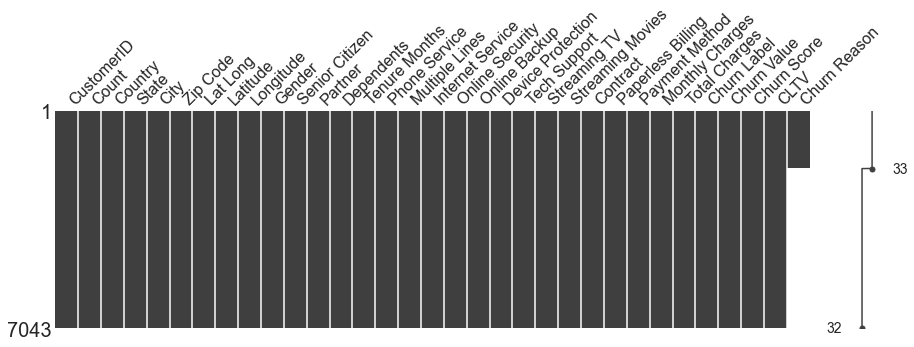

In [10]:
msno.matrix(df, figsize=(15,4))
plt.show()

### Class Distributions
The class distributions will tell whether the data set is balanced or imbalanced, i.e., if the percentage of customers that would remain or leave is very similar, if not equal. Given the nature of the problem, it is expected that the data set will be imbalanced.

In [11]:
def get_class_counts(df, feature):
    '''
    Function that returns the number of examples in each class
    '''
    classes = df[feature].unique()
    class_counts = dict()
    
    for c in classes:
        counts = df[df[feature] == c].shape[0]
        class_counts.update({c: counts})
    
    return class_counts

def get_class_proportions(df, feature):
    '''
    Function that returns the ratio of examples in each class (confirmed and false positive)
    '''
    class_counts = get_class_counts(df, feature)
    
    classes = df[feature].unique()
    total_examples = df[feature].shape[0]
    class_ratios = dict()
    
    for c in classes:
        ratio = np.round(df[df[feature] == c].shape[0] / total_examples, 3)*100
        class_ratios.update({c: ratio})
    
    return class_ratios

class_counts = get_class_counts(df=df, feature='Churn Value')
class_ratios = get_class_proportions(df=df, feature='Churn Value')

# 1 = the customer left the company this quarter. 0 = the customer remained with the company.
class_counts['Left'] = class_counts.pop(1)
class_counts['Remained'] = class_counts.pop(0)
class_ratios['Left'] = class_ratios.pop(1)
class_ratios['Remained'] = class_ratios.pop(0)

print(f'Data set class counts: {class_counts}')
print(f'Data set class ratios: {class_ratios}')

Data set class counts: {'Left': 1869, 'Remained': 5174}
Data set class ratios: {'Left': 26.5, 'Remained': 73.5}


It can be observed that the data set is imbalanced, where 1869 customers, or 26.5% left the company, and 5174, or 73.5% remained in the company. Thus, for balancing the data set SMOTE (Synthetic Minority Oversampling Technique) will be used.

## Preprocessing

According to previous observations, some features will be dropped, and the feature `Total Charges` will be converted to numeric format.

Additionally, the data set will be modelled with CART models, so no feature scaling is needed in the preprocessing steps.

In [12]:
def drop_and_convert(df):
    df = df.copy()
    
    df = df.drop(['CustomerID',
                  'Count',
                  'Country',
                  'State',
                  'City',
                  'Lat Long',
                  'Churn Label',
                  'Churn Reason'
                 ], axis=1)
    
    df['Total Charges'] = pd.to_numeric(df['Total Charges'],
                         errors='coerce' # If 'coerce', then invalid parsing will be set as NaN
                        )
    
    # Convert to category for LightGBM
    for c in df.columns:
        if df[c].dtype == 'object':
            df[c] = df[c].astype('category')

    
    df.loc[(df['Total Charges'].isna()), 'Total Charges'] = 0
    
    return df

In [13]:
df.loc[df['Total Charges'] == ' '].transpose()

,2234,2438,2568,2667,2856,4331,4687,5104,5719,6772,6840
CustomerID,4472-LVYGI,3115-CZMZD,5709-LVOEQ,4367-NUYAO,1371-DWPAZ,7644-OMVMY,3213-VVOLG,2520-SGTTA,2923-ARZLG,4075-WKNIU,2775-SEFEE
Count,1,1,1,1,1,1,1,1,1,1,1
Country,United States,United States,United States,United States,United States,United States,United States,United States,United States,United States,United States
State,California,California,California,California,California,California,California,California,California,California,California
City,San Bernardino,Independence,San Mateo,Cupertino,Redcrest,Los Angeles,Sun City,Ben Lomond,La Verne,Bell,Wilmington
Zip Code,92408,93526,94401,95014,95569,90029,92585,95005,91750,90201,90744
Lat Long,"34.084909, -117.258107","36.869584, -118.189241","37.590421, -122.306467","37.306612, -122.080621","40.363446, -123.835041","34.089953, -118.294824","33.739412, -117.173334","37.078873, -122.090386","34.144703, -117.770299","33.970343, -118.171368","33.782068, -118.262263"
Latitude,34.084909,36.869584,37.590421,37.306612,40.363446,34.089953,33.739412,37.078873,34.144703,33.970343,33.782068
Longitude,-117.258107,-118.189241,-122.306467,-122.080621,-123.835041,-118.294824,-117.173334,-122.090386,-117.770299,-118.171368,-118.262263
Gender,Female,Male,Female,Male,Female,Male,Male,Female,Male,Female,Male


Some examples, 11 in total, have an empty string `" "` as value for `Total Charges`. These are missing values. It can be seen that for those that don't have a value for `Total Charge`, for the feature `Tenure Months` have a value of zero, meaning that they have just subscribed to the service so they haven't been charged yet. Also, these clients all have `Churn Value` set to `0` because they have just signed up. Thus, the values `Total Charges` that are missing will be set to `0`.

In [14]:
df_dc = drop_and_convert(df)
df_dc.head()

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239
1,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701
2,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,86,5372
3,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84,5003
4,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,89,5340


In [15]:
df_dc.dtypes

Zip Code                int64
Latitude              float64
Longitude             float64
Gender               category
Senior Citizen       category
Partner              category
Dependents           category
Tenure Months           int64
Phone Service        category
Multiple Lines       category
Internet Service     category
Online Security      category
Online Backup        category
Device Protection    category
Tech Support         category
Streaming TV         category
Streaming Movies     category
Contract             category
Paperless Billing    category
Payment Method       category
Monthly Charges       float64
Total Charges         float64
Churn Value             int64
Churn Score             int64
CLTV                    int64
dtype: object

In [16]:
df_dc.isnull().sum()

Zip Code             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
Churn Score          0
CLTV                 0
dtype: int64

It may seem that converting the categorial data to numerical is a reasonable thing to do. But this is wrong. Here's why. Let's take the feature `Payment_Method` which has the following options:
1. `Mailed_Check`,
2. `Electronic_Check`,
3. `Bank_Transfer`,
4. `Credit_Card`.

If these categories are converted to numbers 1, 2, 3, and 4, and treated like numerical data, then it would be assumed that 4, which means `Credit_Card`, is more similar to 3, which means `Bank_Transfer`, than it is to 1 or 2, which are other forms of payment. That means the learning algorithms would be more likely to cluster the people with 3s and 4s together, than the people with 4s and 1s together.

If `Payment_Method` is treated like categorical data, then each value is treated as a separate category that is no more or less similar to any of the other category. This is done with the technique called **one-hot encoding**. There are many different ways to do this in Python, but the following are the most popular: `OneHotEncoder()` (from `scikit-learn`), and `get_dummies()` (from `pandas`).

### Split Data into Features and Target

In [17]:
X = df_dc.drop('Churn Value', axis=1)
y = df_dc['Churn Value'] # 1 = the customer left the company this quarter. 0 = the customer remained with the company.

### Split Data into Train and Test Sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

In [19]:
X_train.shape[0], X_test.shape[0]

(5986, 1057)

### SMOTE

SMOTE must be applied only on the training set, and not on the validation set or the test set. Thus, the `pipeline()` class from `imblearn` must be used because it takes care of this. SMOTE performs better when it is combined with under-sampling the majority class. All intermediate steps of the chain should be estimators that implement `fit()` and `transform()` or `fit_resample()`.

In [20]:
def cross_validate_model(clf, name, X_train, y_train, cv=5):
    t0 = time()
    scores = cross_validate(clf, X_train, y_train, scoring=['f1', 'roc_auc'], cv=cv)
    evaluation_minutes = np.round((time() - t0) / 60, 3)
    
    f1_mean = np.nanmean(scores['test_f1'])
    f1_std = np.nanstd(scores['test_f1'])

    auc_mean = np.nanmean(scores['test_roc_auc'])
    auc_std = np.nanstd(scores['test_roc_auc'])

    print(f'F1={f1_mean:.4f} (+/- {f1_std:.4f}) AUC={auc_mean:.4f} (+/- {auc_std:.4f}) \t Evaluated in {evaluation_minutes} minutes. \t [{name}]')

def plot_cm(clf, X_train, y_train):
    cm = confusion_matrix(y_target=y_train, y_predicted=clf.predict(X_train))
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True)
    plt.show()

## Modeling

### Gradient Boosting
`scikit-learn`'s 

In [21]:
gb_clf = GradientBoostingClassifier(learning_rate=0.1,
                                    max_depth=3,
                                    min_samples_split=2,
                                    max_features=1.0,
                                    subsample=1,
                                    random_state=0)

In [22]:
categorical_features = ['Gender',
                        'Senior Citizen',
                        'Partner',
                        'Dependents',
                        'Phone Service',
                        'Multiple Lines',
                        'Internet Service',
                        'Online Security',
                        'Online Backup',
                        'Device Protection',
                        'Tech Support',
                        'Streaming TV',
                        'Streaming Movies',
                        'Contract',
                        'Paperless Billing',
                        'Payment Method'
]
categorical_transformer = OneHotEncoder(sparse = False)

preprocessor = ColumnTransformer([
    ('1hot', categorical_transformer, categorical_features)
], remainder='passthrough', n_jobs=-1)

gbc = Pipeline([
    ('categorical-features', preprocessor),
    ('over-sampling', SMOTE()),
    ('under-sampling', RandomUnderSampler()),
    ('gradient-boosting', gb_clf)
])
gbc

Pipeline(steps=[('categorical-features',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('over-sampling', SMOTE()),
                ('under-sampling', RandomUnderSampler()),
                ('gradient-boosting',
                 GradientBoostingClassifier(max_features=1.0, random_state=0,
                                            subsample=1))])

### `XGBoost` Model

In [23]:
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    gamma=0,
    max_depth=3,
    colsample_bylevel=1,
    subsample=1,
    eval_metric='logloss')
# Set eval_metrics to remove warning
# https://stackoverflow.com/questions/66097701/how-can-i-fix-this-warning-in-xgboost

xgbc = Pipeline([
    ('categorical-features', preprocessor),
    ('over-sampling', SMOTE()),
    ('under-sampling', RandomUnderSampler()),
    ('XGBoost', xgb_clf)
])
xgbc

Pipeline(steps=[('categorical-features',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'P...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=1,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

### `LightGBM` Model

`LightGBM` only supports `category` type, so the categorical features, which are of type `object`, will be converted to type `category`.

`SMOTENC()` is a method that implements SMOTE technique that works with numerical and categorical features. It needs a list of indexes of the categorical features in the data set.

In [24]:
cat_features = list(X_train.select_dtypes('category').columns)
cat_index = [X_train.columns.get_loc(c) for c in X_train.select_dtypes('category').columns]

In [25]:
lgbm_clf = LGBMClassifier(
    learning_rate=0.1,
    num_leaves=31,
    min_data_in_leaf=100,
    categorical_features=cat_features,
    random_state=0,)

lgbmc = Pipeline([
    ('over-sampling', SMOTENC(categorical_features=cat_index)),
    ('under-sampling', RandomUnderSampler()),
    ('lgbm', lgbm_clf)
])
lgbmc

Pipeline(steps=[('over-sampling',
                 SMOTENC(categorical_features=[3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                               14, 15, 16, 17, 18, 19])),
                ('under-sampling', RandomUnderSampler()),
                ('lgbm',
                 LGBMClassifier(categorical_features=['Gender',
                                                      'Senior Citizen',
                                                      'Partner', 'Dependents',
                                                      'Phone Service',
                                                      'Multiple Lines',
                                                      'Internet Service',
                                                      'Online Security',
                                                      'Online Backup',
                                                      'Device Protection',
                                                      'Tech Support',
                                                      'Streaming TV',
                                                      'Streaming Movies',
                                                      'Contract',
                                                      'Paperless Billing',
                                                      'Payment Method'],
                                min_data_in_leaf=100, random_state=0))])

### `CatBoost` Model

`CatBoost` need a list of categorical features, so the list that was used for `LightGBM` is passed here as well. The same goes for the index of the categorical features for `SMOTENC()`.

In [26]:
catb_clf = CatBoostClassifier(
    learning_rate=None,
    max_depth=6,
    leaf_estimation_iterations=1,
    l2_leaf_reg=3,
    eval_metric='F1',
    random_state=0,
    cat_features=cat_features,
    verbose=False,)

catbc = Pipeline([
    ('over-sampling', SMOTENC(categorical_features=cat_index)),
    ('under-sampling', RandomUnderSampler()),
    ('catboost', catb_clf)
])
catbc

Pipeline(steps=[('over-sampling',
                 SMOTENC(categorical_features=[3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                               14, 15, 16, 17, 18, 19])),
                ('under-sampling', RandomUnderSampler()),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000268A157FA60>)])

We can now use the pipeline created as a normal classifier where resampling will happen when calling `fit` and disabled when calling `decision_function`, `predict_proba`, or `predict`.

====================Gradient Boosting Classifier====================
F1=0.8692 (+/- 0.0095) AUC=0.9837 (+/- 0.0021) 	 Evaluated in 0.295 minutes. 	 [Gradient Boosting Classifier]


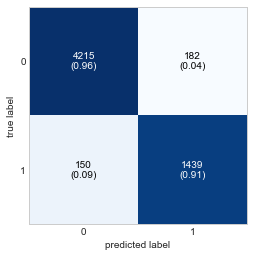

====================XGBoost Classifier====================
F1=0.8755 (+/- 0.0120) AUC=0.9840 (+/- 0.0019) 	 Evaluated in 0.049 minutes. 	 [XGBoost Classifier]


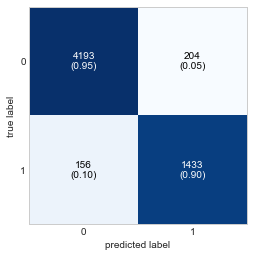

====================LightGBM Classifier====================
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
F1=0.8665 (+/- 0.0101) AUC=0.9818 (+/- 0.0015) 	 Evaluated in 0.11 minutes. 	 [LightGBM Classifier]


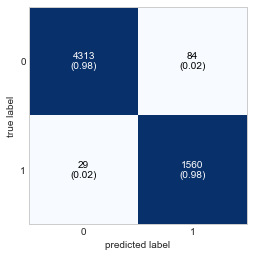

====================CatBoost Classifier====================
F1=0.8726 (+/- 0.0136) AUC=0.9831 (+/- 0.0022) 	 Evaluated in 3.643 minutes. 	 [CatBoost Classifier]


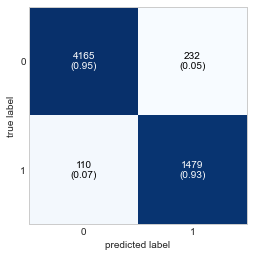

In [27]:
models = [
    gbc,
    xgbc,
    lgbmc,
    catbc,
]

names = [
    'Gradient Boosting Classifier',
    'XGBoost Classifier',
    'LightGBM Classifier',
    'CatBoost Classifier',
]

for model, name in zip(models, names):
    print('='*20 + name + '='*20)
    model.fit(X_train, y_train)
    cross_validate_model(clf=model, name=name, X_train=X_train, y_train=y_train, cv=5)
    plot_cm(clf=model, X_train=X_train, y_train=y_train)

## Hyper-parameter Optimization

In [28]:
def randomized_seach(estimator, param_distributions, X_train, y_train, n_iter=20, scoring='f1', cv=5):
    t0 = time()
    
    estimator_opt = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        n_jobs=-1,
        cv=cv).fit(X_train, y_train)
    
    grid_searching_time = np.round((time() - t0) / 60, 3)

    print(f'Grid searching time: {grid_searching_time:.4f} minutes.')
    print(f'{estimator_opt.best_score_:.4f}')
    print(f'{estimator_opt.best_estimator_}')
    
    return estimator_opt

### Optimization of Gradient Boosting

In [29]:
param_grid_gbc = {'gradient-boosting__learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
                  'gradient-boosting__max_depth': [2, 3, 5, 7, 10, None],
                  'gradient-boosting__min_samples_split': [2, 5, 10, 20],
                  'gradient-boosting__max_features': ['log2', 'sqrt', 0.25, 1.0],
                  'gradient-boosting__subsample': [0.15, 0.5, 0.75, 1.0]
                  }

gbc_opt = randomized_seach(estimator=gbc,
                           param_distributions=param_grid_gbc,
                           X_train=X_train,
                           y_train=y_train,)

Grid searching time: 1.0340 minutes.
0.8740
Pipeline(steps=[('categorical-features',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',


### Optimization of `XGBoost ` Model

In [30]:
param_grid_xgbc = {
    'XGBoost__learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
    'XGBoost__gamma': [0, 0.1, 0.2, 0.3, 0.4, 1.0, 1.5, 2.0],
    'XGBoost__max_depth': [2, 3, 5, 7, 10, 100],
    'XGBoost__colsample_bylevel': ['log2', 'sqrt', 0.25, 1.0],
    'XGBoost__subsample': [0.15, 0.5, 0.75, 1.0],
}

xgbc_opt = randomized_seach(estimator=xgbc,
                            param_distributions=param_grid_xgbc,
                            X_train=X_train,
                            y_train=y_train,)

Grid searching time: 0.3440 minutes.
0.8760
Pipeline(steps=[('categorical-features',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',


### Optimization of `LightGBM` Model

In [31]:
param_grid_lgbmc = {
    'lgbm__learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
    'lgbm__num_leaves': [3, 7, 15, 31, 127, 1024],
    'lgbm__min_data_in_leaf': [100, 300, 500, 1000, 1500],
}

lgbmc_opt = randomized_seach(estimator=lgbmc,
                             param_distributions=param_grid_lgbmc,
                             X_train=X_train,
                             y_train=y_train,)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Grid searching time: 0.9330 minutes.
0.8722
Pipeline(steps=[('over-sampling',
                 SMOTENC(categorical_features=[3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                               14, 15, 16, 17, 18, 19])),
                ('under-sampling', RandomUnderSampler()),
                ('lgbm',
                 LGBMClassifier(categorical_features=['Gender',
                                                      'Senior Citizen',
                                                      'Partner', 'Dependents',
                                                      'Phone Service',
                                                      'Multiple Lines',
                                                      'Internet Service',
                                                      'Online Security',
                                                      '

### Optimization of `CatBoost` Model

In [32]:
param_grid_catbc = {
    'catboost__iterations': [100, 250, 500, 1000],
    'catboost__learning_rate': np.arange(0.001, 10, 30),
    'catboost__max_depth': [6, 7, 8, 9, 10],
    'catboost__l2_leaf_reg': np.arange(1, 100, 30)
}

catbc_opt = randomized_seach(estimator=catbc,
                             param_distributions=param_grid_catbc,
                             X_train=X_train,
                             y_train=y_train,)

Grid searching time: 12.7720 minutes.
0.8580
Pipeline(steps=[('over-sampling',
                 SMOTENC(categorical_features=[3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                               14, 15, 16, 17, 18, 19])),
                ('under-sampling', RandomUnderSampler()),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000268A1A1D940>)])


## Evaluating models

### Evaluation of models with default hyperparameters

====================Gradient Boosting Classifier====================
Accuracy score: 0.9338
Precision score: 0.8571
Recall score: 0.9000
F1 score: 0.8780
AUC score: 0.9855


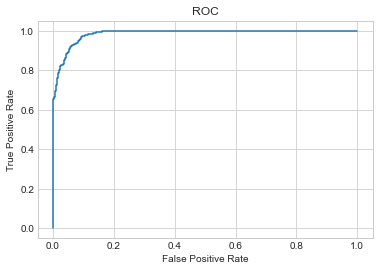




====================XGBoost Classifier====================
Accuracy score: 0.9309
Precision score: 0.8462
Recall score: 0.9036
F1 score: 0.8739
AUC score: 0.9850


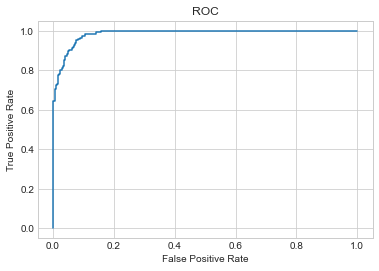




====================LightGBM Classifier====================
Accuracy score: 0.9357
Precision score: 0.8533
Recall score: 0.9143
F1 score: 0.8828
AUC score: 0.9845


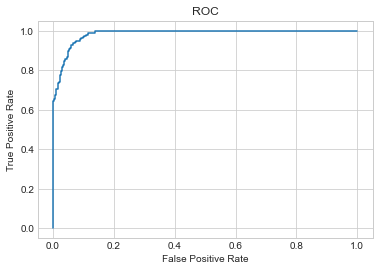




====================CatBoost Classifier====================
Accuracy score: 0.9328
Precision score: 0.8404
Recall score: 0.9214
F1 score: 0.8790
AUC score: 0.9844


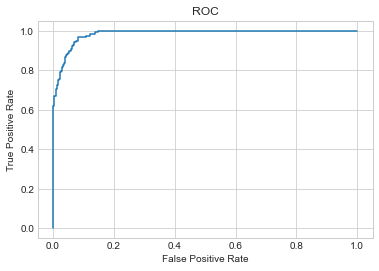

In [33]:
default_models = [
    gbc,
    xgbc,
    lgbmc,
    catbc,
]

default_names = [
    'Gradient Boosting Classifier',
    'XGBoost Classifier',
    'LightGBM Classifier',
    'CatBoost Classifier',
]

Models = []
Accuracy_scores = []
Precision_scores = []
Recall_scores = []
F1_scores = []
AUC_scores = []

for model, name in zip(default_models, default_names):
    print('='*20 + name + '='*20)
    
    Accuracy_score = accuracy_score(y_test, model.predict(X_test))
    Precision_score = precision_score(y_test, model.predict(X_test))
    Recall_score = recall_score(y_test, model.predict(X_test))
    F1_score = f1_score(y_test, model.predict(X_test))
    Roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    print(f'Accuracy score: {Accuracy_score:.4f}')
    print(f'Precision score: {Precision_score:.4f}')
    print(f'Recall score: {Recall_score:.4f}')
    print(f'F1 score: {F1_score:.4f}')
    print(f'AUC score: {Roc_auc_score:.4f}')
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    
    plt.plot(fpr, tpr, label=f'{name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    
    Models.append(name)
    Accuracy_scores.append(Accuracy_score)
    Precision_scores.append(Precision_score)
    Recall_scores.append(Recall_score)
    F1_scores.append(F1_score)
    AUC_scores.append(Roc_auc_score)
    print('\n\n')

In [34]:
summary_default = pd.DataFrame({
    'Model': Models,
    'Accuracy Score': Accuracy_scores,
    'Precision Score': Precision_scores,
    'Recall Score': Recall_scores,
    'F1 Score': F1_scores,
    'AUC Score': AUC_scores,
})
summary_default.sort_values('F1 Score', ascending=False)

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,AUC Score
2,LightGBM Classifier,0.935667,0.853333,0.914286,0.882759,0.984524
3,CatBoost Classifier,0.932829,0.840391,0.921429,0.879046,0.984436
0,Gradient Boosting Classifier,0.933775,0.857143,0.900000,0.878049,0.985503
1,XGBoost Classifier,0.930937,0.846154,0.903571,0.873921,0.985011


### Evaluation of models with optimized hyperparameters

====================Gradient Boosting Classifier - tuned====================
Accuracy score: 0.9347
Precision score: 0.8702
Recall score: 0.8857
F1 score: 0.8779
AUC score: 0.9840


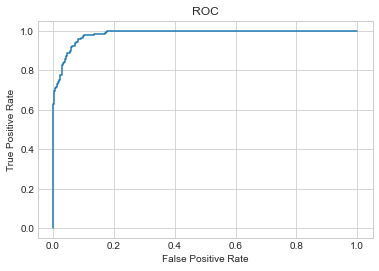




====================XGBoost Classifier - tuned====================
Accuracy score: 0.9309
Precision score: 0.8581
Recall score: 0.8857
F1 score: 0.8717
AUC score: 0.9830


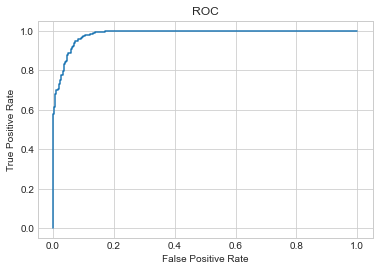




====================LightGBM Classifier - tuned====================
Accuracy score: 0.9338
Precision score: 0.8344
Recall score: 0.9357
F1 score: 0.8822
AUC score: 0.9849


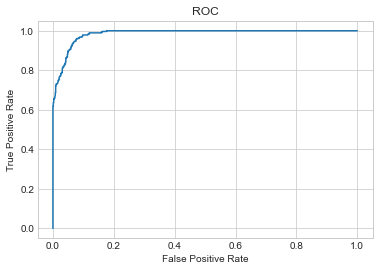




====================CatBoost Classifier - tuned====================
Accuracy score: 0.9196
Precision score: 0.8019
Recall score: 0.9250
F1 score: 0.8590
AUC score: 0.9802


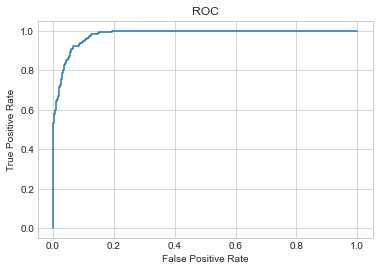

In [35]:
optimized_models = [
    gbc_opt,
    xgbc_opt,
    lgbmc_opt,
    catbc_opt,
]

optimized_names = [
    'Gradient Boosting Classifier - tuned',
    'XGBoost Classifier - tuned',
    'LightGBM Classifier - tuned',
    'CatBoost Classifier - tuned',
]

Models = []
Accuracy_scores = []
Precision_scores = []
Recall_scores = []
F1_scores = []
AUC_scores = []

for model, name in zip(optimized_models, optimized_names):
    print('='*20 + name + '='*20)
    
    Accuracy_score = accuracy_score(y_test, model.predict(X_test))
    Precision_score = precision_score(y_test, model.predict(X_test))
    Recall_score = recall_score(y_test, model.predict(X_test))
    F1_score = f1_score(y_test, model.predict(X_test))
    Roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    print(f'Accuracy score: {Accuracy_score:.4f}')
    print(f'Precision score: {Precision_score:.4f}')
    print(f'Recall score: {Recall_score:.4f}')
    print(f'F1 score: {F1_score:.4f}')
    print(f'AUC score: {Roc_auc_score:.4f}')
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    
    plt.plot(fpr, tpr, label=f'{name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    
    Models.append(name)
    Accuracy_scores.append(Accuracy_score)
    Precision_scores.append(Precision_score)
    Recall_scores.append(Recall_score)
    F1_scores.append(F1_score)
    AUC_scores.append(Roc_auc_score)
    print('\n\n')

In [36]:
summary_opt = pd.DataFrame({
    'Model': Models,
    'Accuracy Score': Accuracy_scores,
    'Precision Score': Precision_scores,
    'Recall Score': Recall_scores,
    'F1 Score': F1_scores,
    'AUC Score': AUC_scores,
})
summary_opt.sort_values('F1 Score', ascending=False)

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,AUC Score
2,LightGBM Classifier - tuned,0.933775,0.834395,0.935714,0.882155,0.984885
0,Gradient Boosting Classifier - tuned,0.934721,0.870175,0.885714,0.877876,0.984018
1,XGBoost Classifier - tuned,0.930937,0.858131,0.885714,0.871705,0.983007
3,CatBoost Classifier - tuned,0.919584,0.801858,0.925000,0.859038,0.980249


In [37]:
summary = pd.concat([summary_default, summary_opt])
summary.sort_values('F1 Score', ascending=False)

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,AUC Score
2,LightGBM Classifier,0.935667,0.853333,0.914286,0.882759,0.984524
2,LightGBM Classifier - tuned,0.933775,0.834395,0.935714,0.882155,0.984885
3,CatBoost Classifier,0.932829,0.840391,0.921429,0.879046,0.984436
0,Gradient Boosting Classifier,0.933775,0.857143,0.900000,0.878049,0.985503
0,Gradient Boosting Classifier - tuned,0.934721,0.870175,0.885714,0.877876,0.984018
1,XGBoost Classifier,0.930937,0.846154,0.903571,0.873921,0.985011
1,XGBoost Classifier - tuned,0.930937,0.858131,0.885714,0.871705,0.983007
3,CatBoost Classifier - tuned,0.919584,0.801858,0.925000,0.859038,0.980249


## References
1. https://community.ibm.com/accelerators/catalog/content/Telco-customer-churn
2. https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113
3. https://www.youtube.com/watch?v=GrJP9FLV3FE&ab_channel=StatQuestwithJoshStarmer
4. https://imbalanced-learn.org/stable/auto_examples/pipeline/plot_pipeline_classification.html#sphx-glr-auto-examples-pipeline-plot-pipeline-classification-py
5. Bentéjac, C., Csörgő, A. & Martínez-Muñoz, G. A comparative analysis of gradient boosting algorithms. Artif Intell Rev 54, 1937–1967 (2021). https://doi.org/10.1007/s10462-020-09896-5